# Querying MinIO with BlazingSQL

BlazingSQL is an open-source project, and as such, we gladly receive feature requests on our Github repository all the time. One such request ([#242](https://github.com/BlazingDB/blazingsql/issues/242)) was to allow registering a Storage Plugin that was AWS S3 API compliant, in this case MinIO.

> MinIO is a high performance, Kubernetes-friendly, object store released open source under the Apache License v2.0. It is API compatible with Amazon S3 cloud storage service. Using MinIO, you can build high performance infrastructure for machine learning, analytics and application data workloads.

In this Notebook, we'll go over how to install MinIO Server and register a MinIO bucket with BlazingSQL so we can run queries on top of files that are stored in a MinIO cluster.

In [1]:
from blazingsql import BlazingContext
bc = BlazingContext()

BlazingContext ready


### Set Up MinIO Server
MinIO can be deployed on Linux, Kubernetes, MacOS, Windows and with Source. This demo was built in an Ubuntu 18.04 environment, so we’ll set up MinIO for Linux.

Start by downloading the MinIO Server. The code cell below will download MinIO Server one level above where you are running this Notebook.

In [2]:
!wget -P .. https://dl.min.io/server/minio/release/linux-amd64/minio

--2020-04-23 09:14:46--  https://dl.min.io/server/minio/release/linux-amd64/minio
Resolving dl.min.io (dl.min.io)... 178.128.69.202
Connecting to dl.min.io (dl.min.io)|178.128.69.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48787456 (47M) [application/octet-stream]
Saving to: ‘../minio’

minio               100%[===================>]  46.53M  17.1MB/s    in 2.7s    

2020-04-23 09:14:49 (17.1 MB/s) - ‘../minio’ saved [48787456/48787456]



Once the download completes, simply grant permissions with; 

In [3]:
!chmod +x ../minio

### Launch MinIO Server
MinIO Server installed, you’re now equipped to start a Server by calling `./minio server` followed the relative path to where you’d like the Server to run. In this case, we’re going to set up inside the `Welcome_to_BlazingSQL_Notebooks` repo. 

**Note**: running a continuous server in a Jupyter Notebook Code cell means that cell will execute until the server is turned off, so you will not be able to run the MinIO Server within this Notebook and complete the demo simultaneously. Please start a Terminal session with the JupyterLab Launcher and run the Server from there with `./minio server .`.

In [4]:
# !../minio server .

<img src="../data/imgs/minio_server.png" width="69%" />

### Register MinIO S3 bucker
With the Server running in `Welcome_to_BlazingSQL_Noteooks`, all of the repo's sub-directories have automatically are accessable as S3 buckets.

For this demo, we'll use data stored in the `data` bucket. As this bucket is not public, we'll need to input our `access_key_id` and `secret_key`.

To help BlazingSQL locate MinIO bucket, we'll also input the Server's URL as the `endpoint_override`.

`endpoint_override` is a new parameter that was added with [BlazingDB/blazingsql#524](https://github.com/BlazingDB/blazingsql/pull/524) to support MinIO S3 by extending our AWS S3 Storage Plugin to use custom URL endpoints.

In [5]:
bc.s3('taxi', 
      bucket_name='data',
      access_key_id='minioadmin', 
      secret_key='minioadmin',
      endpoint_override="http://127.0.0.1:9000")

(True,
 '',
 OrderedDict([('type', 's3'),
              ('bucket_name', 'data'),
              ('access_key_id', 'minioadmin'),
              ('secret_key', 'minioadmin'),
              ('session_token', ''),
              ('encryption_type', <S3EncryptionType.NONE: 1>),
              ('kms_key_amazon_resource_name', ''),
              ('endpoint_override', 'http://127.0.0.1:9000')]))

### Create & Query table from MinIO S3 bucket

Now that the MinIO S3 bucket is registered with BlazingContext, we can easily create & query tables from data stored there.

In [6]:
bc.create_table('taxi', 's3://taxi/sample_taxi.csv')

And pull DataFrames from those tables with `.sql()`;

In [7]:
bc.sql("select * from taxi")

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_x,pickup_y,RateCodeID,store_and_fwd_flag,dropoff_x,dropoff_y,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount
0,2,2015-03-05 07:38:36,2015-03-05 07:44:06,1,1.10,-8235279.565,4975191.631,1,N,-8235303.346,4973620.602,1,6.0,0.0,0.5,2.00,0.0,8.80
1,1,2015-02-03 05:41:55,2015-02-03 05:46:54,1,0.70,-8235656.655,4972873.569,1,N,-8236483.024,4973822.361,1,5.5,0.5,0.5,1.36,0.0,8.16
2,2,2015-02-08 16:17:51,2015-02-08 16:37:45,1,3.65,-8238228.336,4974965.742,1,N,-8233503.678,4978004.758,2,16.0,0.0,0.5,0.00,0.0,16.80
3,2,2015-03-07 02:17:05,2015-03-07 02:22:18,3,0.77,-8232200.852,4980818.134,1,N,-8231245.389,4980848.420,2,5.5,0.5,0.5,0.00,0.0,6.80
4,2,2015-02-05 21:05:35,2015-02-05 21:10:33,2,0.74,-8236124.619,4973741.097,1,N,-8234966.173,4972970.518,1,5.5,0.5,0.5,1.00,0.0,7.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2,2015-02-23 22:14:26,2015-02-23 22:17:34,1,0.89,-8233236.149,4978496.493,1,N,-8231928.226,4979053.300,2,5.0,0.5,0.5,0.00,0.0,6.30
999996,2,2015-01-22 03:46:03,2015-01-22 03:49:51,1,1.62,-8235466.411,4980026.247,1,N,-8234375.060,4982699.404,2,6.5,0.5,0.5,0.00,0.0,0.30
999997,2,2015-02-05 16:19:05,2015-02-05 16:38:43,2,5.20,-8234358.074,4982376.298,1,N,-8236800.662,4974834.022,1,19.5,1.0,0.5,5.32,0.0,26.62
999998,2,2015-01-27 18:29:36,2015-01-27 18:40:06,1,1.91,-8238416.031,4968924.713,1,N,-8236314.013,4971218.867,1,9.5,1.0,0.5,2.26,0.0,0.30


Handoff results to data viz packages like Matplotlib the same way;

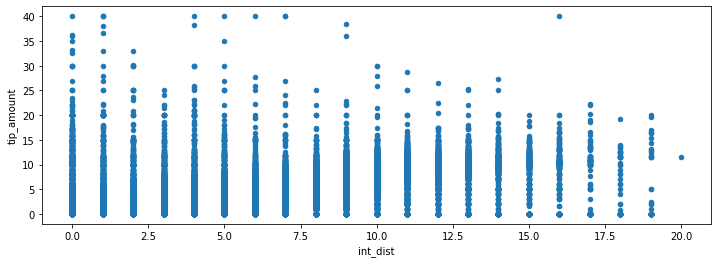

In [8]:
query = '''
        SELECT 
            cast(trip_distance as int) int_dist, tip_amount 
        FROM 
            taxi
            WHERE
                trip_distance <= 20
                AND tip_amount BETWEEN 0 AND 40
                '''
bc.sql(query).to_pandas().plot(kind='scatter', x='int_dist', y='tip_amount', figsize=(12, 4))

Train machine learning models with suites like cuML;

In [9]:
from cuml import LinearRegression
lr = LinearRegression()

lr.fit(X=bc.sql('SELECT tip_amount, passenger_count FROM taxi'),
       y=bc.sql('SELECT trip_distance FROM taxi')['trip_distance'])

import cudf
df = cudf.DataFrame()

df['tip_amount'] = [0.00, 5.00, 20.00]
df['passenger_count'] = [1.0, 1.0, 1.0]

lr.predict(df)

0     5.958761
1    21.315652
2    67.386324
dtype: float64

Or whatever else you please!

<a href='https://app.blazingsql.com/jupyter/user-redirect/lab/workspaces/auto-b/tree/Welcome_to_BlazingSQL_Notebooks/blog_posts/minio.ipynb'><img src="https://blazingsql.com/launch-notebooks.png" alt="Launch on BlazingSQL Notebooks" width="500"/></a>